# Edge Detection

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from osgeo import gdal
from scipy import ndimage
from skimage import feature
import numpy as np
import glob
import os
from skimage.morphology import disk,square
from skimage.filters import rank
from collections import namedtuple

In [2]:
def write_geotiff(fname, data, ds, data_type=gdal.GDT_Float32):#data_type=gdal.GDT_Float32):
    driver = gdal.GetDriverByName('GTiff')
    dataset = driver.Create(fname, ds.RasterXSize,ds.RasterYSize, 1, data_type)
    dataset.SetGeoTransform(ds.GetGeoTransform())
    dataset.SetProjection(ds.GetProjection())
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)

    dataset = None  # Close the file
    return 

In [3]:
cd /mnt/i/planet/andrew

/mnt/i/planet/andrew


In [7]:
ds = gdal.Open('20210910_panchromatic_AnalyticMS_SR_clip.tif', gdal.GA_ReadOnly)
data = ds.GetRasterBand(1).ReadAsArray()[550:1200,500:1150]
# ds = None

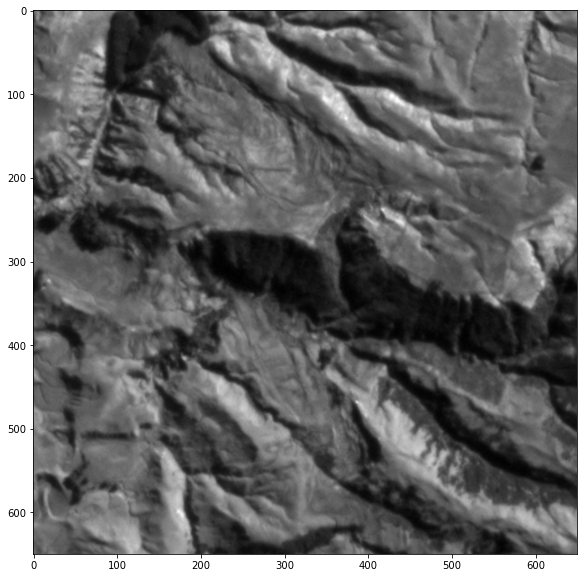

In [8]:
f = plt.figure(figsize=(10,10))
plt.imshow(data,cmap='gray')

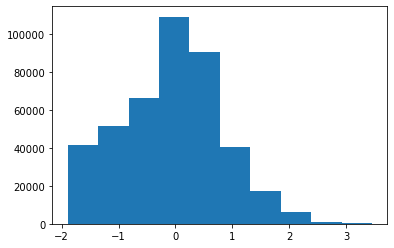

In [23]:
h = plt.hist(data.flatten())

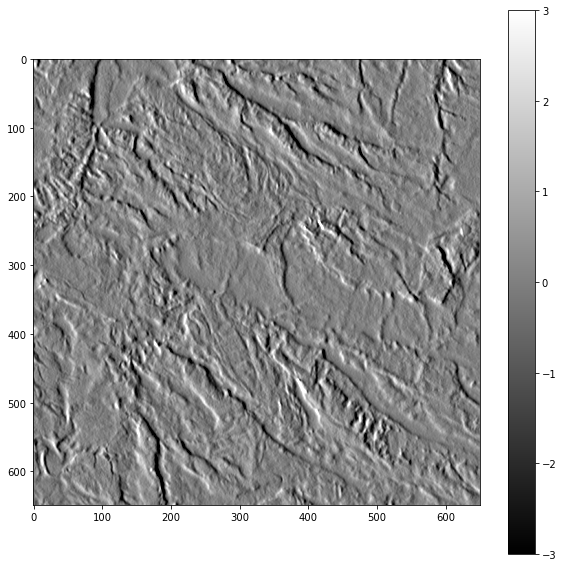

In [29]:
sobel = ndimage.sobel(data)
f = plt.figure(figsize=(10,10))
plt.imshow(sobel,cmap='gray',vmin=-3,vmax=3)
plt.colorbar()

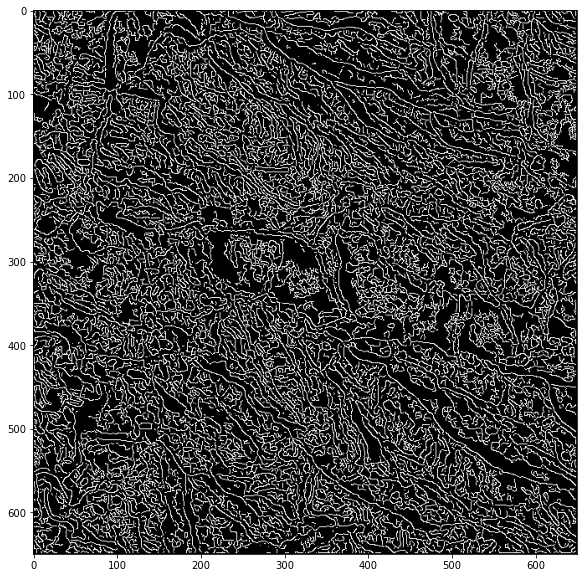

In [25]:
canny = feature.canny(data,sigma=0.5,low_threshold=0.0,high_threshold=0.5,use_quantiles=True)
f = plt.figure(figsize=(10,10))
plt.imshow(canny,cmap='gray')

LOL no.

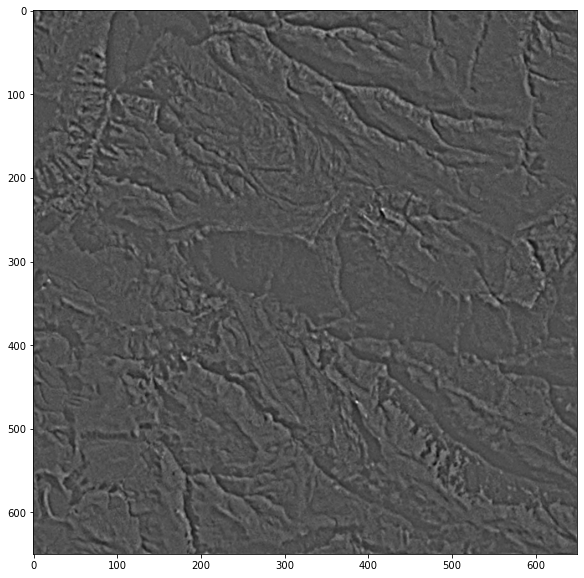

In [26]:
passfilt = data - ndimage.gaussian_filter(data, 2)
f = plt.figure(figsize=(10,10))
plt.imshow(passfilt,cmap='gray')

estimated noise standard deviation = 0.012821583622399676


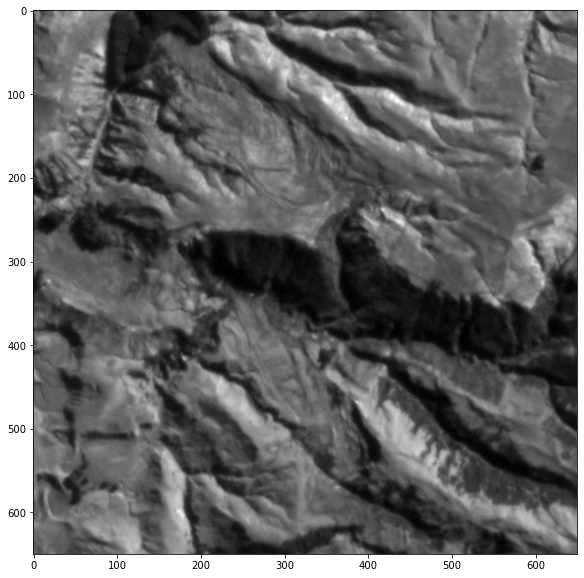

In [27]:
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio

# estimate the noise standard deviation from the noisy image
sigma_est = np.mean(estimate_sigma(data))
print(f'estimated noise standard deviation = {sigma_est}')

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6)  # 13x13 search area

# fast algorithm
nl_means = denoise_nl_means(data, h=0.8 * sigma_est, fast_mode=True, **patch_kw)

f = plt.figure(figsize=(10,10))
plt.imshow(nl_means,cmap='gray')

In [18]:
# loc = rank.equalize(data, square(4))
# f = plt.figure(figsize=(20,10))
# plt.imshow(loc,cmap='gray')

In [20]:
data

array([[1.8809587e-01, 2.7853972e-01, 4.0178040e-01, ..., 9.0101027e-01,
        1.0170887e+00, 1.1124009e+00],
       [1.3437682e-01, 2.3915927e-01, 3.8145572e-01, ..., 8.2284820e-01,
        9.9114287e-01, 1.1525156e+00],
       [4.4395064e-04, 1.6387337e-01, 3.4144464e-01, ..., 8.4557128e-01,
        1.0107419e+00, 1.2334285e+00],
       ...,
       [2.7163446e-01, 2.5991973e-01, 2.3101024e-01, ..., 2.6361084e-01,
        2.4206600e-01, 2.2545688e-01],
       [2.6575348e-01, 2.6075915e-01, 2.6854408e-01, ..., 1.9767387e-01,
        2.2916378e-01, 2.3110628e-01],
       [3.0897811e-01, 3.0146307e-01, 2.7299720e-01, ..., 1.4779735e-01,
        2.1724038e-01, 2.3479998e-01]], dtype=float32)

In [19]:
loc = rank.equalize(data, disk(8))
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(data,cmap='gray')
ax2.imshow(loc,cmap='gray')

ValueError: Images of type float must be between -1 and 1.

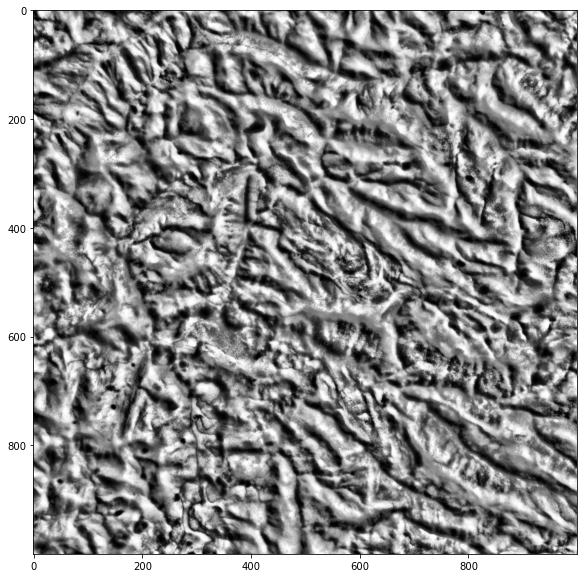

In [24]:
from skimage import exposure

# equalize globally and locally
glob = exposure.equalize_hist(data) * 255
f = plt.figure(figsize=(10,10))
plt.imshow(loc,cmap='gray')

### Processing

In [88]:
# fnames = glob.glob('*AnalyticMS_SR_clip*tif')
# [f'{x.split(".")[0]}_filt.tif' for x in fnames]

In [96]:
types = {'planet':{'files':'*AnalyticMS_SR*tif','date_loc':slice(0,8)},
        'sentinel2':{'files':'s2*tif','date_loc':slice(-12,-4)}}

meta = types['planet']
pattern = meta['files']
date_loc = meta['date_loc']

In [106]:
Image = namedtuple('Image','date file')
names = [Image(os.path.basename(x)[date_loc],x) for x in glob.glob(pattern)]

merged = [x for x in names if 'merged' in x.file]
for m in merged:
    names = [x for x in names if m.date != x.date]

names += merged
names

[Image(date='20200903', file='20200903_212616_52_2212_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20210910', file='20210910_212429_42_2439_3B_AnalyticMS_SR_clip.tif'),
 Image(date='20170911', file='20170911_merged_AnalyticMS_SR_clip.tif'),
 Image(date='20180909', file='20180909_merged_AnalyticMS_SR_clip.tif'),
 Image(date='20190918', file='20190918_merged_AnalyticMS_SR_clip.tif')]

In [107]:
for n in names:
    f = n.file
    ds = gdal.Open(f, gdal.GA_ReadOnly)
    data = ds.ReadAsArray()
    
    means = data.mean(axis=(1,2))
    stds = data.std(axis=(1,2))
    normed = (data - means[:,None,None]) / stds[:,None,None]
    pan = normed.mean(axis=0)
    out_name = '_'.join(f.split('_')[:1]+['panchromatic']+f.split('_')[-3:])
    print(f'Writing {out_name}...')
    
    write_geotiff(out_name,pan,ds)
    ds = None

print('done!')

Writing 20200903_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20210910_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20170911_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20180909_panchromatic_AnalyticMS_SR_clip.tif...
Writing 20190918_panchromatic_AnalyticMS_SR_clip.tif...


In [33]:
fnames = glob.glob('*panchromatic*tif')
for f in fnames:
    ds = gdal.Open(f, gdal.GA_ReadOnly)
    data = ds.GetRasterBand(1).ReadAsArray()
    sobel = ndimage.sobel(data)

    parts = f.split('_')
    out_name = '_'.join(parts[:1]+['sobel']+parts[-3:])
    write_geotiff(out_name,sobel,ds)
    
    ds = None